## Step 1: Query all recently annoated Cotton images

In [25]:
import pandas as pd
import time
import numpy as np
from matplotlib import pyplot as plt, rcParams

import brtdevkit
from brtdevkit.core.db import DBConnector, DatetimeFilter
from brtdevkit.core.db.db_filters import *  # We need this for pre-defined filters, e.g., ProjectFilter, DatetimeFilter

from warnings import filterwarnings
filterwarnings("ignore")

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations. 
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

start = datetime(2020,3,29) # The first field was collected on 3/30/2021
end = datetime(2021, 10, 1)

filters = {"artifacts.kind": "nrg",
           "crop_name" : 'COTTON', 
           'has_human_annotation': True
          }

cotton_df, elapsed_time = get_shasta_data(filters=filters, start=start, end=end)
cotton_df['grower_farm_field'] = cotton_df['grower'] + '_' + cotton_df['farm'] + '_' + cotton_df['operating_field_name']
print(f"Queried {len(cotton_df)} images in {elapsed_time:.2f} s.")

Queried 110283 images in 901.10 s.


### Step 2: Remove any identical lat / long / camera_serial combinations

In [2]:
start_len = len(cotton_df)
cotton_df = cotton_df.drop_duplicates(subset=['latitude', 'longitude', 'camera_serial'], keep='first')
print(f'{start_len - len(cotton_df)} images were removed due to Identical Lat/Long/Camera_serial combos.')

2 images were removed due to Identical Lat/Long/Camera_serial combos.


## Step 3: Check for Low Solar Angles

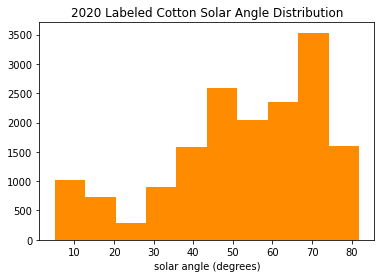

There are 0 cotton images from 0 fields with < 5 degree solar angles.


In [4]:
# Code to add solar_angle numbers to the dataframe

import datetime
from timezonefinder import TimezoneFinderL
import pytz
from pysolar.solar import *

# You can instantiate the TimezoneFinder() oject inside the function if needed, but it will slow down the computation about 15%
tf = TimezoneFinderL()

def get_solar_angle(timestamp, latitude, longitude):
    """
    Requires datetime, TimezonefinderL, pytz and pysolar libraries
    
    Inputs: Timestamp, latitude, longitude.
    Outputs: Solar angle between (-90 , 90). Daylight conditions will always be > 0.
    """
    # Localize and adjust UTC timestamps to local timezone
    utc = pytz.utc.localize(timestamp)
    tz = tf.timezone_at(lat=latitude, lng=longitude)
    adjusted_timestamp = utc.astimezone(tz)

    # If there are invalid GPS coordinates, the function will return 'NaN'
    if adjusted_timestamp.tzinfo is not None:
        return get_altitude(latitude, longitude, adjusted_timestamp)
    else:
        return float('NaN')

# apply to brtdevkit DataFrame with 'collected_on', 'latitude' and 'longitude' columns
cotton_df['solar_angle'] = cotton_df.apply(lambda x: get_solar_angle(x['collected_on'], x['latitude'], x['longitude']), axis=1)
plt.hist(cotton_df['solar_angle'], color='darkorange')
plt.title('2020 Labeled Cotton Solar Angle Distribution')
plt.xlabel('solar angle (degrees)')
plt.show()

print(f'There are {len(cotton_df[cotton_df.solar_angle < 5])} cotton images from {len(cotton_df[cotton_df.solar_angle < 5].operating_field_name.unique())} fields with < 5 degree solar angles.')

## Step 4: Validate Annotations (most recent version, have s3_keys, etc)

In [66]:
# Flatten annotations to make them easily searchable

def flatten_annotations(dataframe):
    r = pd.DataFrame(
        {
            col:np.repeat(dataframe[col].values, dataframe['annotations'].str.len())
            for col in dataframe.columns.drop('annotations')
        }).assign(**{'annotations':np.concatenate(dataframe['annotations'].values)})[dataframe.columns]
    w = pd.concat([
        r.drop(['annotations'], axis=1),
        r['annotations'].apply(pd.Series).add_suffix('_annotations')
    ],
    axis=1)
    # Return filtered dataframe with each annotation artifact as a single row. 
    # Filter out ndvi and machine labels 
    return w[(w['kind_annotations'] != 'machine') & (w['kind_annotations'] != 'ndvi_mask')]

flat = flatten_annotations(cotton_df)
print(f'There are {len(flat)} total annotations from {len(flat._id.unique())} unique image ids')

There are 397637 total annotations from 110283 unique image ids


In [67]:
oi = flat[flat['_id'].isin(cotton_subsampled_test['id'])]

flat = oi[(oi['state_annotations']=='ok') & (oi.next_version_annotations.isnull()==True)]
len(flat)

1385

In [68]:
# Reomove any annotations that have a more recent version (e.g. from an audit or correction)

flat = flat[(flat['state_annotations']=='ok') & (flat.next_version_annotations.isnull()==True)]
flat.next_version_annotations.isnull().value_counts()

True    1385
Name: next_version_annotations, dtype: int64

In [80]:
np.mean(flat.created_at_annotations)

Timestamp('2021-06-30 19:34:51.536691712')

In [69]:
# Sort for the most recent annotations of each id
flat = flat.sort_values(by='created_at_annotations', ascending =True, axis=0)

# Romove any duplicate image ids
# annotations_final is now our master list of annotations used to create the annotation datasets
annotations_final = flat.drop_duplicates(subset=['_id'], keep='last')
print(f'There are {len(annotations_final)} annotated images that are valid.')

There are 1373 annotated images that are valid.


In [70]:
# Verify all annotations are pixelwise style 
annotations_final = flat[flat['group_id'].isin(cotton_subsampled_test['group_id'])]
#cotton_subsampled_test[cotton_subsampled_test['group_id'].isin(flat['group_id'])]

annotations_final.style_annotations.value_counts()

pixelwise    1385
Name: style_annotations, dtype: int64

In [71]:
# Sort for the most recent annotations of each id
annotations_final = annotations_final.sort_values(by='created_at_annotations', ascending =True, axis=0)

# Romove any duplicate image ids
# annotations_final is now our master list of annotations used to create the annotation datasets
annotations_final = annotations_final.drop_duplicates(subset=['_id'], keep='last')
print(f'There are {len(annotations_final)} annotated images that are valid.')

There are 1373 annotated images that are valid.


In [72]:
# Creating string versions of some metadata fields to be able to search through them. (There's probably a better way to do this)
annotations_final['nv'] = annotations_final.next_version_annotations.astype(str)
annotations_final['lm'] = annotations_final.label_map_annotations.astype(str)
annotations_final['s3k'] = annotations_final.s3_key_annotations.apply(str)
annotations_final['s3b'] = annotations_final.s3_bucket_annotations.apply(str)

# There are now no images with nans for label_map, s3_bucket and s3_key
print(len(annotations_final[(annotations_final['lm']== 'nan') | (annotations_final['s3k']== 'nan') | (annotations_final['s3b']== 'nan')]))
# There are no annotations with next_version is not null (meaning there is no newer version)
print(len(annotations_final[annotations_final.nv.isnull()==True]))

# This cell should output zeros and only one label map. Otherwise, there is something wrong. 
annotations_final['lm'].value_counts()

0
0


{'1': 'weed', '2': 'crop'}    1373
Name: lm, dtype: int64

In [74]:
# Look at which label policies were used

annotations_final['lp'] = annotations_final.label_policy_annotations.astype(str)

# cotton label policy is '6083224ccfbd2a9d788f2988'
# corn label policy is '607653583f4e7e93319cc306' 
# soy label policy is '608a9197e607efcba438d878'
# weed only label policy is '5f8a02ff6b7133e8cd0aac62'

#chosen_fields = annotations_final[annotations_final['lp']!='608a9197e607efcba438d878']
annotations_final = annotations_final[annotations_final['lp']!='608a9197e607efcba438d878']
print(annotations_final.lp.value_counts())

5eb48622e154067231d8121b    863
6083224ccfbd2a9d788f2988    510
Name: lp, dtype: int64


In [11]:
# When ready, limit the annotations to just the fields with sufficient labels
labels_2021 = chosen_fields[['_id', 'grower','_id_annotations']]

print(f'There are {len(labels_2021)} images from {len(chosen_fields.grower_farm_field.unique())} fields ready to use.')

There are 16313 images from 148 fields ready to use.


## Examine fields on map

In [19]:
# Examine Fields in Map to Ensure They are Unique
import folium

fields = chosen_fields.groupby('grower_farm_field').median().reset_index()[['grower_farm_field','latitude', 'longitude']]

# Generate base_map for adding points
def generateBaseMap(default_location=[36, -100], default_zoom_start=4.25):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
base_map = generateBaseMap()

# Add fields to the base_map
for i in range(len(fields)):
    folium.Marker(location=[fields.latitude[i], fields.longitude[i]],popup= fields.grower_farm_field[i]).add_to(base_map)

base_map

## Load 2020 Datasets and merge with the new 2021 data

In [64]:
# Load 2020 datasets plus relabel cotton
from brtdevkit.data import Dataset

# Retrieve 2020 datasets from Aletheia 
holdout_2020 = Dataset.retrieve(name = "Q12021_holdout_test_set_cotton_annotation_v5").to_dataframe()[['id','operating_field_name','group_id' ,'annotation_pixelwise_0__id']]
all_folds_2020 =Dataset.retrieve(name = "Q12021_All_Folds_Cotton_Image_v4").to_dataframe()[['id','operating_field_name','grower','group_id' ,'annotation_pixelwise_0__id']]
hq_test = Dataset.retrieve(name= 'Q12021_holdout_test_set_high_quality_cotton_annotation_v1.1').to_dataframe()[['id','operating_field_name','grower','group_id','annotation_pixelwise_0__id']]

# Relabeled cotton datasets
relabel_test = Dataset.retrieve(name = "Q22021_holdout_test_set_high_quality_cotton_relabel_v0").to_dataframe()[['id','operating_field_name','grower','group_id', 'annotation_pixelwise_0__id']]
relabel_train = Dataset.retrieve(name = "Q22021_All_Folds_Cotton_Image_relabel_v0").to_dataframe()[['id','operating_field_name','grower','group_id', 'annotation_pixelwise_0__id']]

In [13]:
# If you want to update just one set
from brtdevkit.data import Dataset

cotton_test = Dataset.retrieve(name ='062821_Cotton_Test_2021_v1').to_dataframe()[['id','operating_field_name','group_id' ,'annotation_pixelwise_0__id']]
cotton_subsampled_test = Dataset.retrieve(name ='062921_Cotton_Subsampled_Test_Set_v1').to_dataframe()[['id','operating_field_name','group_id' ,'annotation_pixelwise_0__id']]

In [65]:
# filter out any group_ids from before the relabeling

print(len(all_folds_2020))
print(len(relabel_train))
all_folds_2020 = all_folds_2020[~all_folds_2020['group_id'].isin(relabel_train['group_id'])]
revised_train = pd.concat([all_folds_2020, relabel_train], axis=0)
print(len(revised_train))
print(len(revised_train.group_id.unique()))

60140
60140
60140
60140


In [66]:
print(len(holdout_2020))
print(len(relabel_test))

holdout_2020 = holdout_2020[~holdout_2020['group_id'].isin(relabel_test['group_id'])]
revised_test = pd.concat([holdout_2020, relabel_test], axis=0)

print(len(revised_test))
revised_test = revised_test[revised_test.group_id != '135b77f2-fec3-4376-b137-1338d530009b']
revised_test = revised_test[revised_test.group_id != '778b4499-d008-4e3e-979a-c401b8654c59']

print(len(revised_test))
print(len(revised_test.group_id.unique()))

# remove mislabeled soybean field
revised_test = revised_test[revised_test.operating_field_name!='mv-13']

13705
585
13707
13703
13703


In [67]:
# The cotton data is special because the relabeled images need to replace the older labels

#revised_train = revised_train[['id', 'grower' ,'annotation_pixelwise_0__id']]

print(len(revised_train))
revised_train = revised_train[~revised_train['id'].isin(hq_test['id'])]
print(len(revised_train))
print(len(revised_train[revised_train['id'].isin(hq_test['id'])]))

60140
60140
0


In [68]:
# Dictionary of grower names to fix { incorrect_name : correct_name }
fix_grower_names = {'Pual Burt': 'Paul Bert', 
                   'Schronk Agri' : 'Todd Schronk', 
                   'Steven Beakley' : 'Steven Beakly',
                   'Jeff Baize': 'Jeff Blaize',
                    'Chris Hajovsky':'Chris Hajovsky CLH Farms',
                   'Chris Hajovsky CLH farms': 'Chris Hajovsky CLH Farms',
                   "Jon Gwynn's Cotton":'jon gwynn',
                    'Jon gwynn':'jon gwynn',
                   'Toby  Robertson': 'Toby Robertson',
                   'chad phillipe':'Chad Fillipe',
                    'doug scott' : 'Doug Scott',
                    'eddie smith':'Eddie Smith',
                    'd&l farms partnership':'d&l farms',
                    'tyson price':'Tyson Price',
                    'wildy familyfarms':'wildy family farms',
                   'mac kutzenberger':'Mac Kutzenberger',
                   'matt coley': 'Matt Coley',
                    'mike watz': 'Mike Watz',
                   'neil lee':'Neil Lee',
                   'rodney dawson':'Rodney Dawson',
                    'skiles': 'Skiles',
                    'trey davis': 'Trey Davis',
                   'tyler deen':'Tyler Deen',
                   'tyler dean':'Tyler Deen'}

revised_train['grower'] = revised_train['grower'].map(fix_grower_names).fillna(revised_train['grower'])
print(f'After cleaning, there are {len(revised_train.grower.unique())} unique growers in the trainging set.')
revised_test['grower'] = revised_test['grower'].map(fix_grower_names).fillna(revised_test['grower'])
print(f'After cleaning, there are {len(revised_test.grower.unique())} unique growers in the 2020 test set.')
labels_2021['grower'] = labels_2021['grower'].map(fix_grower_names).fillna(labels_2021['grower'])
print(f'After cleaning, there are {len(labels_2021.grower.unique())} unique growers in the 2021 data.')

# Drops any of the same growers in train/test from the train set
#revised_train = revised_train[~revised_train['grower'].isin(list(holdout_2020.grower.unique()))]

total_unique = len(set(list(labels_2021.grower.unique()) + list(revised_train.grower.unique()) + list(revised_test.grower.unique())))
print(f'We now have {total_unique} unique growers to split.')

After cleaning, there are 40 unique growers in the trainging set.
After cleaning, there are 11 unique growers in the 2020 test set.
After cleaning, there are 47 unique growers in the 2021 data.
We now have 92 unique growers to split.


In [69]:
# 64, 18, 10

revised_test = revised_test[['id', 'grower', 'annotation_pixelwise_0__id']]
revised_train = revised_train[['id', 'grower', 'annotation_pixelwise_0__id']]

labels_2021.columns = ['id','grower','annotation_id']
revised_test.columns = ['id','grower','annotation_id']
revised_train.columns = ['id','grower','annotation_id']

overlap_train = labels_2021[labels_2021['grower'].isin(revised_train['grower'].unique())].grower.unique()
print(f'{len(overlap_train)} growers from 2021 are present in the train set')

overlap_test = labels_2021[labels_2021['grower'].isin(revised_test['grower'].unique())].grower.unique()
print(f'{len(overlap_test)} growers from 2021 are present in the test set')
all_growers_2020 = list(revised_test['grower'].unique()) + list(revised_train['grower'].unique())

no_overlap = labels_2021[~labels_2021['grower'].isin(all_growers_2020)].grower.unique()
print(f'{len(no_overlap)} growers from 2021 are not present in any older dataset')

5 growers from 2021 are present in the train set
1 growers from 2021 are present in the test set
41 growers from 2021 are not present in any older dataset


In [70]:
# Create Dev set from growers not present in the train or test datasets
# Number of growers is 20 or 10% of total
from random import shuffle
shuffle(no_overlap)

n_dev_growers = 10
dev_growers =  no_overlap[0:n_dev_growers]
no_overlap = no_overlap[n_dev_growers:]

dev_set = labels_2021[labels_2021['grower'].isin(dev_growers)]
print(f'There are {len(dev_set.grower.unique())} growers in the dev set and {len(dev_set)} labeled images.')
print(f'there are now {len(no_overlap)} growers still available')

There are 10 growers in the dev set and 3580 labeled images.
there are now 31 growers still available


In [73]:
# Create Test set

test_2021 = labels_2021[labels_2021['grower'].isin(revised_test['grower'].unique())]
final_test = pd.concat([revised_test, test_2021], axis=0)
still_needed = 18 - len(final_test.grower.unique())
print(f'We need {still_needed} more growers to get to 20%')
new_test_growers = no_overlap[0:still_needed]
no_overlap= no_overlap[still_needed:]
print(f'There are still {len(no_overlap)} growers available.')

final_test = pd.concat([final_test, labels_2021[labels_2021['grower'].isin(new_test_growers)]], axis=0)
len(final_test.grower.unique())

We need 7 more growers to get to 20%
There are still 24 growers available.


18

In [74]:
# Create Train Set

train_2021 = labels_2021[labels_2021['grower'].isin(revised_train['grower'].unique())]

final_train = pd.concat([revised_train, train_2021], axis=0)

still_needed = 64 - len(final_train.grower.unique())
print(f'We need {still_needed} more growers to get to 70%')
new_train_growers = no_overlap[0:still_needed]
print(len(new_train_growers))
no_overlap= no_overlap[still_needed:]
print(f'There are now {len(no_overlap)} growers left over.')
final_train = pd.concat([final_train, labels_2021[labels_2021['grower'].isin(new_train_growers)]], axis=0)
len(final_train.grower.unique())

We need 24 more growers to get to 70%
24
There are now 0 growers left over.


64

### Check for leakage betwen 2020 and 2021

In [76]:
# Check for overlapping ids between new train and old test, new test and old train. Shoould output all zeros. 

print(len(final_train[final_train.id.isin(holdout_2020.id.unique())].id.unique()))
print(len(final_train[final_train.id.isin(revised_test.id.unique())].id.unique()))
print(len(final_test[final_test.id.isin(revised_train.id.unique())].id.unique()))

0
0
0


In [77]:
# Check for any growers present in different sets. Should output all zeros

print(len(final_train[final_train.grower.isin(final_test.grower.unique())].grower.unique()))
print(len(final_train[final_train.grower.isin(dev_set.grower.unique())].grower.unique()))
print(len(final_test[final_test.grower.isin(final_train.grower.unique())].grower.unique()))
print(len(final_test[final_test.grower.isin(dev_set.grower.unique())].grower.unique()))
print(len(dev_set[dev_set.grower.isin(final_test.grower.unique())].grower.unique()))
print(len(dev_set[dev_set.grower.isin(final_train.grower.unique())].grower.unique()))

0
0
0
0
0
0


In [78]:
# Check for any annotation_ids present in multiple sets. Should output all zeros

print(len(final_train[final_train.annotation_id.isin(final_test.annotation_id.unique())].annotation_id.unique()))
print(len(final_train[final_train.annotation_id.isin(dev_set.annotation_id.unique())].annotation_id.unique()))
print(len(final_test[final_test.annotation_id.isin(final_train.annotation_id.unique())].annotation_id.unique()))
print(len(final_test[final_test.annotation_id.isin(dev_set.annotation_id.unique())].annotation_id.unique()))
print(len(dev_set[dev_set.annotation_id.isin(final_test.annotation_id.unique())].annotation_id.unique()))
print(len(dev_set[dev_set.annotation_id.isin(final_train.annotation_id.unique())].annotation_id.unique()))

0
0
0
0
0
0


In [79]:
# Check for any ids present in multiple sets. Should output all zeros

print(len(final_train[final_train.id.isin(final_test.id.unique())].id.unique()))
print(len(final_train[final_train.id.isin(dev_set.id.unique())].id.unique()))
print(len(final_test[final_test.id.isin(final_train.id.unique())].id.unique()))
print(len(final_test[final_test.id.isin(dev_set.id.unique())].id.unique()))
print(len(dev_set[dev_set.id.isin(final_test.id.unique())].id.unique()))
print(len(dev_set[dev_set.id.isin(final_train.id.unique())].id.unique()))

0
0
0
0
0
0


## Final Step: Choose which folds to include in the 2020 + 2021 Dataset 

In [75]:
len(annotations_final._id.unique())

1373

In [77]:
rev_list = list(annotations_final._id_annotations.astype(str))
print(len(rev_list))
print(len(rev_list))
rev_list[0:5]

1373
1373


['5ec617bd2480f46f8cc98a5d',
 '5ec617bd2480f46f8cc98a86',
 '5ec617bd2480f46f8cc98aa5',
 '5ec64d31d0e1c52c12cc3e49',
 '5ec64d31d0e1c52c12cc3e78']

In [80]:
print(len(dev_set))
print(len(dev_set.grower.unique()))
dev_list = list(dev_set.annotation_id.astype(str))
print(len(dev_list))
dev_list[0:5]
#dev_set.head()

3580
10
3580


['60878355ce9bead79bada04e',
 '60878355ce9bead79bada063',
 '60878355ce9bead79bada0ae',
 '60878356ce9bead79bada114',
 '60878356ce9bead79bada117']

In [81]:
print(len(final_train))
print(len(final_train.grower.unique()))
train_list = list(final_train.annotation_id.astype(str))
print(len(train_list))
train_list[0:5]

67726
64
67726


['5ed84cb4e01f2a41ff86f5b4',
 '5ed84cb4e01f2a41ff86f5de',
 '5ee051aee42699bc0074d17f',
 '5ee0540bc1c4c0c4a547d099',
 '5ee054f80dfa7551223a15a7']

In [82]:
print(len(final_test))
print(len(final_test.grower.unique()))
test_list = list(final_test.annotation_id.astype(str))
print(len(test_list))
test_list[0:5]

15466
18
15466


['5ec61761d0e1c52c12cc2ea7',
 '5ec61761d0e1c52c12cc2ead',
 '5ec61761d0e1c52c12cc2eaf',
 '5ec61761d0e1c52c12cc2eb2',
 '5ec617bd2480f46f8cc98a55']

## Finally, create the dataset

In [78]:
from brtdevkit.data import Dataset

# Enter a name and description
dataset_name= '071221_Cotton_subsampled_Test_2021_v1'
description = '2021 Cotton Subsampled Test set with 30 images per field. 2020 and 2021 data.'

Dataset.create(
    name= dataset_name,
    description = description,
    kind = Dataset.KIND_ANNOTATION,
    annotation_ids = rev_list
    )

{}

In [81]:
# After a few seconds, retreive the dataset to verify it has been created properly
dsn = '071221_Cotton_subsampled_Test_2021_v1'
dset = Dataset.retrieve(name = dsn)
ddd = dset.to_dataframe()

print(len(ddd))
ddd.columns

1373


AttributeError: 'DataFrame' object has no attribute 'state_annotations'

In [82]:
print(len(ddd))
ddd.columns[0:30]

1373


Index(['angle_to_row', 'annotation_pixelwise_0__cls',
       'annotation_pixelwise_0__id',
       'annotation_pixelwise_0_annotation_job_id',
       'annotation_pixelwise_0_audit_at', 'annotation_pixelwise_0_audit_by',
       'annotation_pixelwise_0_audit_mistakes',
       'annotation_pixelwise_0_audit_requested',
       'annotation_pixelwise_0_created_at',
       'annotation_pixelwise_0_is_active_version',
       'annotation_pixelwise_0_is_deleted', 'annotation_pixelwise_0_kind',
       'annotation_pixelwise_0_label_map',
       'annotation_pixelwise_0_label_policy',
       'annotation_pixelwise_0_labeled_objects',
       'annotation_pixelwise_0_mask_height',
       'annotation_pixelwise_0_mask_width',
       'annotation_pixelwise_0_nothing_to_annotate',
       'annotation_pixelwise_0_prev_version',
       'annotation_pixelwise_0_promote_to_review',
       'annotation_pixelwise_0_review_reasons',
       'annotation_pixelwise_0_review_request',
       'annotation_pixelwise_0_s3_bucket'

In [83]:
ddd.annotation_pixelwise_0_state.value_counts()

ok    1373
Name: annotation_pixelwise_0_state, dtype: int64

In [92]:
from brtdevkit.data import Dataset
import numpy as np

train_cotton = Dataset.retrieve(name = "070821_Cotton_Train_Set_v2").to_dataframe()
#test_cotton['grower_farm_field'] = test_cotton['grower'] + '_' + test_cotton['farm'] + '_' + test_cotton['operating_field_name']

#np.min(test_cotton.grower_farm_field.value_counts())
train_cotton.annotation_pixelwise_0_next_version.isnull().value_counts()

KeyboardInterrupt: 

In [87]:
good_ids = list(train_cotton[train_cotton.annotation_pixelwise_0_next_version.isnull()==True]['annotation_pixelwise_0__id'].astype(str))
print(len(good_ids))
good_ids[0:5]

67513


['5ed84cb4e01f2a41ff86f58a',
 '5ed84cb4e01f2a41ff86f5b4',
 '5ed84cb4e01f2a41ff86f5de',
 '5ee051aee42699bc0074d17f',
 '5ee0540bc1c4c0c4a547d099']

In [105]:
bad_id_ids = list(train_cotton[train_cotton['annotation_pixelwise_0__id'].isin(bad_ids)])
print(len(bad_id_ids))
bad_ids[0:5]

114


['609bab5bdad15a622ed69671',
 '60b802ac47fe9f92b9f1ed8e',
 '60b802ac47fe9f92b9f1edee',
 '60d165564f56b7a7ba679685',
 '60d166a8dc578ccc0270037c']

In [95]:

bad_ideas = pd.Series(bad_ids, name='annotation_id')
bad_ideas.to_csv('070821_cotton_train_v1_v2_delta.csv')

In [72]:
replace = train_cotton[train_cotton['annotation_pixelwise_0__id'].isin(bad_ids)]

In [74]:
# brtdevkit
import brtdevkit
import pandas as pd
from brtdevkit.core.db import DBConnector
from brtdevkit.core.db.db_filters import *  # We need this for pre-defined filters, e.g., ProjectFilter, DatetimeFilter
import brtdevkit.util.s3 as brt_s3

def get_specific_fields(df, artifact = 'nrg'):
    """
    Takes a dataframe with specific [grower, farm, operating_field_name] combinations and retreives document records from 
    Aletheia matching just those fields. Useful when you  need a collection of fields but don't want to query the entire record.
    :param: df: a pandas dataframe with [grower, farm, operating_field_name] columns.
    :param: artifact: The type of artifact you want to return. Default is 'nrg'
     """
    db = DBConnector()
    filters = {'grower': df['grower'].iloc[0], 'farm': df['farm'].iloc[0],'operating_field_name': df['operating_field_name'].iloc[0]}
    img_filters = {'project_name': 'shasta', **filters, 'artifacts.kind':artifact}
    master_df = db.get_documents_df('image', img_filters, limit=None)
    for n in range(len(df[1:])):
        filters = {'grower': str(df['grower'].iloc[n]), 'farm': str(df['farm'].iloc[n]),'operating_field_name': str(df['operating_field_name'].iloc[n])}
        img_filters = {'project_name': 'shasta', **filters, 'artifacts.kind':artifact}
        field_df = db.get_documents_df('image', img_filters, limit=None)
        if len(field_df)==0:
            print(f'Could not find field: { df.operating_field_name[n]} from grower: {df.grower[n]}')
        master_df = pd.concat([master_df, field_df], axis=0)
    print(f'Query returned {len(master_df)} {artifact} records.')
    return master_df

replacement_df = get_specific_fields(replace)
print(len(replacement_df))

Query returned 229315 nrg records.
229315


In [10]:
# I needed to filter out fields with < 30 images.
under = ['john lavigne_howard management_hwy 258 2','murry henderson_murry henderson_airstrip east',
'john lavigne_howard management_hwy 258 1',
'bobby lowrey_lowrey farms_ab-11',
'bobby lowrey_lowrey farms_bp-w6']

test_cotton = test_cotton[~test_cotton.grower_farm_field.isin(under)]
test_cotton.grower_farm_field.value_counts()

goodman planting llc_yucatan_YU07                              938
goodman planting llc_yucatan_YU09                              916
joe powell_powell farms_mlk & powell rd                        910
goodman planting llc_yucatan_YU08                              781
joe powell_powell farms_old ridge rd                           761
goodman planting llc_yucatan_YU05                              736
james connelly_connelly_section 4E                             715
james connelly_connelly_section 2B                             704
james connelly_connelly_section 76                             688
murry henderson_airstrip_airstrip east                         666
Quentin Scheildknight_Quentin section 5_setion 5               652
james connelly_connelly_section 3N                             647
james connelly_connelly section 3_section3 n                   532
wildy family farms_wildy_40                                    479
d&l farms partnership_gm lawrence_mrc 8                       

In [11]:
from random import shuffle

sample_ids = []

#in the future when you upgrade to pandas 1.1 use this next line:
# sampled = test_corn.groupby("grower_farm_field").apply(sample(n=30, random_state=1))

for f in test_cotton.grower_farm_field.unique():
    sub = test_cotton[test_cotton['grower_farm_field']==f]
    
    sub_id = list(sub['annotation_pixelwise_0__id'])
    shuffle(sub_id)
    sample_ids = sample_ids + (sub_id[0:30])

print(len(sample_ids))
print(len(test_cotton.grower_farm_field.unique())*30)
sample_ids[0:5]

1380
1380


['5fca058d32b9facad1bf0214',
 '5fc34f74b92af6556b33c47c',
 '5fb75c2b3441f1e25ad81c04',
 '5fc37cb82514352a3003ae07',
 '5fc9abf45fcaf3b2698dcf59']

In [89]:
# Enter a name and description
dataset_name= '070821_Cotton_Train_Set_v2'
description = 'A Cotton training set with all outdated annotations updated.'

Dataset.create(
    name= dataset_name,
    description = description,
    kind = Dataset.KIND_ANNOTATION,
    annotation_ids = better
    )

{}

In [22]:
subsampled[subsampled.annotation_pixelwise_0_next_version.isnull()==False][['id', 'collected_on']]

,id,collected_on
164,5ee3bf999a4f6250eb632f96,2020-06-06T18:20:34.360000
182,5ed7d4cdf24b09f116868cf2,2020-05-21T16:50:40.487000
188,5ee3c337d64a16b66e1e758a,2020-06-06T17:27:25.360000
192,5ed7d67ff24b09f1168697ae,2020-05-21T16:12:34.487000
216,5ecff49c2eaf95468a80338c,2020-05-14T21:32:22.455000
217,5ecff6f8f7e010813e7830d5,2020-05-14T21:32:44.455000
220,5ed7ff9fe48cb092ca1d940c,2020-05-28T21:09:40.321000
238,5ed7e35be2bdff4580ca46e4,2020-05-25T17:42:16.305000
244,5f05ff1787e980c1d08f8122,2020-06-25T21:24:50.798000
248,5ed0047586930d57c5f1f7f8,2020-05-14T21:33:50.455000


In [13]:
bad_ids = ['5ecff49c2eaf95468a80338c','5ecff6f8f7e010813e7830d5','5ed7ff9fe48cb092ca1d940c','5ed7fec7e48cb092ca1d9344']
for i in bad_ids:
    print(subsampled[subsampled['id']==i]['annotation_pixelwise_0__id'])
    print(subsampled[subsampled['id']==i]['annotation_pixelwise_0__id'])

216    5f779a35e7c911dcbc363038
Name: annotation_pixelwise_0__id, dtype: object
217    5f779a35e7c911dcbc36303b
Name: annotation_pixelwise_0__id, dtype: object
220    5f779a36e7c911dcbc36321e
Name: annotation_pixelwise_0__id, dtype: object
385    5fb22e278a6ccd2d48f6a8d4
Name: annotation_pixelwise_0__id, dtype: object


### Plan of Attack

* Get the ids that have more up-to-date annotations
* Filter out the bad annotations from the training set
* Find the newer versions of the bad annotations
* Add that to the filtered dataset
* Create new training dataset

In [88]:
better = good_ids + dev_list
print(len(better))

67725
